# Feature Engineering
## Feature Engineering Goals
1.  **Categorical Feature Encoding**: Convert nominal and ordinal categorical features into numerical representations.
    - **Ordinal**: `age`, `education`, `experience_overall_years`, `experience_field_years`.
    - **Nominal (Low Cardinality)**: `gender`.
    - **Nominal (High Cardinality/Text)**: `industry`, `job`, `race`. These require careful handling to extract meaningful information.
2.  **Numerical Feature Engineering**: Create new features through combinations or transformations of existing numerical and ordinal features (e.g., interaction terms, ratios).
3.  **Feature Scaling**: Standardize numerical features for models sensitive to feature scales.

In [121]:
# Imports
import json
from pathlib import Path

import polars as pl
from sklearn.preprocessing import StandardScaler
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
# Constants
CLEANED_FILE_PATH: str = "../../data/cleaned/regression"

In [123]:
# Load Feature Sets
output_dir = Path(CLEANED_FILE_PATH)
X_train = pl.read_csv(output_dir / "X_train.csv")
X_val = pl.read_csv(output_dir / "X_val.csv")
X_test = pl.read_csv(output_dir / "X_test.csv")

## Ordinal Feature Encoding
Features like `age`, `education`, and `experience` have a natural order. We will map these categories to numerical ranks to preserve this information.

In [124]:
# Define Ordinal Categories in Order
age_order: list[str] = [
    "under 18",
    "18-24",
    "25-34",
    "35-44",
    "45-54",
    "55-64",
    "65 or over",
]

education_order: list[str] = [
    "High School",
    "Some college",
    "College degree",
    "Professional degree (MD, JD, etc.)",
    "Master's degree",
    "PhD",
]

experience_order: list[str] = [
    "1 year or less",
    "2 - 4 years",
    "5-7 years",
    "8 - 10 years",
    "11 - 20 years",
    "21 - 30 years",
    "31 - 40 years",
    "41 years or more",
]

ordinal_mappings: dict[str, dict[int, str]] = {
    "age": age_order,
    "education": education_order,
    "experience_overall_years": experience_order,
    "experience_field_years": experience_order,
}

In [125]:
def apply_ordinal_encoding(df: pl.DataFrame) -> pl.DataFrame:
    """Applies direct ordinal mapping to specified columns."""
    for key, value in ordinal_mappings.items():
        df = df.with_columns(
            pl.col(key).cast(pl.Enum(value)).cast(pl.Int32).alias(f"{key}_ordinal")
        )

    return df.drop(ordinal_mappings.keys())

In [126]:
# Apply Ordinal Encoding
X_train_encoded = apply_ordinal_encoding(X_train)
X_test_encoded = apply_ordinal_encoding(X_test)
X_val_encoded = apply_ordinal_encoding(X_val)
X_train_encoded

industry,gender,race,job,timestamp,age_ordinal,education_ordinal,experience_overall_years_ordinal,experience_field_years_ordinal
str,str,str,str,str,i32,i32,i32,i32
"""Marketing, Advertising & PR""","""Woman""","""White""","""Senior Music Producer""","""4/27/2021 20:11:25""",2,2,3,3
"""Computing or Tech""","""Other or prefer not to answer""","""Another option not listed here…","""senior sysadmin""","""4/27/2021 12:32:58""",4,1,5,5
"""Insurance""","""Woman""","""White""","""Product Manager""","""4/29/2021 21:42:15""",4,2,5,5
"""Computing or Tech""","""Man""","""White""","""Front End Engineer ""","""4/27/2021 21:21:13""",3,2,4,1
"""Computing or Tech""","""Man""","""White""","""Customer service ""","""4/28/2021 14:19:39""",4,2,5,4
…,…,…,…,…,…,…,…,…
"""Business or Consulting""","""Woman""","""White""","""Principal Research Analyst""","""4/29/2021 11:01:07""",2,2,2,2
"""Utilities & Telecommunications""","""Woman""","""Asian or Asian American""","""Development Consultant""","""5/3/2021 15:50:48""",4,2,5,4
"""Education (Higher Education)""","""Woman""","""White""","""Director of Disability and Acc…","""4/28/2021 15:23:08""",3,4,4,4


## One-Hot Encoding
Features like `gender`, `race`, and `industry` have no inherent ranking, so One-Hot Encoding is appropriate.

Since gender is a single-choice question, just encode the gender column into its preset choices.

In [127]:
# Polars has a convenient to_dummies() function for One-Hot Encoding
X_train_encoded = X_train_encoded.to_dummies("gender")
X_test_encoded = X_test_encoded.to_dummies("gender")
X_val_encoded = X_val_encoded.to_dummies("gender")
X_train_encoded

industry,gender_Man,gender_Non-binary,gender_Other or prefer not to answer,gender_Woman,race,job,timestamp,age_ordinal,education_ordinal,experience_overall_years_ordinal,experience_field_years_ordinal
str,u8,u8,u8,u8,str,str,str,i32,i32,i32,i32
"""Marketing, Advertising & PR""",0,0,0,1,"""White""","""Senior Music Producer""","""4/27/2021 20:11:25""",2,2,3,3
"""Computing or Tech""",0,0,1,0,"""Another option not listed here…","""senior sysadmin""","""4/27/2021 12:32:58""",4,1,5,5
"""Insurance""",0,0,0,1,"""White""","""Product Manager""","""4/29/2021 21:42:15""",4,2,5,5
"""Computing or Tech""",1,0,0,0,"""White""","""Front End Engineer ""","""4/27/2021 21:21:13""",3,2,4,1
"""Computing or Tech""",1,0,0,0,"""White""","""Customer service ""","""4/28/2021 14:19:39""",4,2,5,4
…,…,…,…,…,…,…,…,…,…,…,…
"""Business or Consulting""",0,0,0,1,"""White""","""Principal Research Analyst""","""4/29/2021 11:01:07""",2,2,2,2
"""Utilities & Telecommunications""",0,0,0,1,"""Asian or Asian American""","""Development Consultant""","""5/3/2021 15:50:48""",4,2,5,4
"""Education (Higher Education)""",0,0,0,1,"""White""","""Director of Disability and Acc…","""4/28/2021 15:23:08""",3,4,4,4


`race` and `industry` are more complicated, as they are multiple-choice responses in the survey.

For our purposes, we will encode the preset choices given in the survey, and filter out the free-text responses to reduce cardinality and decrease encodings.

In [128]:
# List out preset choices
# All commas are removed since they mess with the encoding process
PRESET_RACE_OPTIONS: list[str] = [
    "White",
    "Asian or Asian American",
    "Black or African American",
    "Hispanic Latino or Spanish origin",
    "Middle Eastern or Northern African",
    "Native American or Alaska Native",
    "Another option not listed here or prefer not to answer",
]
PRESET_RACE_OPTIONS.sort()

PRESET_INDUSTRY_OPTIONS: list[str] = [
    "Accounting Banking & Finance",
    "Agriculture or Forestry",
    "Art & Design",
    "Business or Consulting",
    "Computing or Tech",
    "Education (Primary/Secondary)",
    "Education (Higher Education)",
    "Engineering or Manufacturing",
    "Entertainment",
    "Government and Public Administration",
    "Health care",
    "Hospitality & Events",
    "Insurance",
    "Law",
    "Law Enforcement & Security",
    "Leisure Sport & Tourism",
    "Marketing Advertising & PR",
    "Media & Digital",
    "Nonprofits",
    "Property or Construction",
    "Recruitment or HR",
    "Retail",
    "Sales",
    "Social Work",
    "Transport or Logistics",
    "Utilities & Telecommunications",
]

In [129]:
def apply_one_hot_encoding(df: pl.DataFrame) -> pl.DataFrame:
    # Remove all commas
    df = df.with_columns(
        pl.col("industry").str.replace_all(r",", "").alias("industry"),
        pl.col("race").str.replace_all(r",", "").alias("race"),
    )

    # Add Index
    df = df.with_row_index()

    # Industry
    df_industry = (df
        .select(pl.col("index"), pl.col("industry").str.split(","))
        .with_columns(pl.lit(1).alias("__one__"))
        .explode("industry")
        .pivot(index="index", on="industry", values="__one__")
        .select(["index"] + (PRESET_INDUSTRY_OPTIONS))
        .fill_null(0)
        .rename({option: f"industry_{option}" for option in PRESET_INDUSTRY_OPTIONS})
    )

    # Race
    df_race = (df
         .select(pl.col("index"), pl.col("race").str.split(","))
        .with_columns(pl.lit(1).alias("__one__"))
        .explode("race")
        .pivot(index="index", on="race", values="__one__")
        .select(["index"] + (PRESET_RACE_OPTIONS))
        .fill_null(0)
        .rename({option: f"race_{option}" for option in PRESET_RACE_OPTIONS})
        )

    # Drop Raw Columns
    return (df
        .join(df_industry, on="index")
        .join(df_race, on="index")
        .drop(["industry", "race"]))

In [130]:
# Remove all commas and add index
X_train_one_hot = apply_one_hot_encoding(X_train_encoded)
X_test_one_hot = apply_one_hot_encoding(X_test_encoded)
X_val_one_hot = apply_one_hot_encoding(X_val_encoded)

X_train_one_hot

index,gender_Man,gender_Non-binary,gender_Other or prefer not to answer,gender_Woman,job,timestamp,age_ordinal,education_ordinal,experience_overall_years_ordinal,experience_field_years_ordinal,industry_Accounting Banking & Finance,industry_Agriculture or Forestry,industry_Art & Design,industry_Business or Consulting,industry_Computing or Tech,industry_Education (Primary/Secondary),industry_Education (Higher Education),industry_Engineering or Manufacturing,industry_Entertainment,industry_Government and Public Administration,industry_Health care,industry_Hospitality & Events,industry_Insurance,industry_Law,industry_Law Enforcement & Security,industry_Leisure Sport & Tourism,industry_Marketing Advertising & PR,industry_Media & Digital,industry_Nonprofits,industry_Property or Construction,industry_Recruitment or HR,industry_Retail,industry_Sales,industry_Social Work,industry_Transport or Logistics,industry_Utilities & Telecommunications,race_Another option not listed here or prefer not to answer,race_Asian or Asian American,race_Black or African American,race_Hispanic Latino or Spanish origin,race_Middle Eastern or Northern African,race_Native American or Alaska Native,race_White
u32,u8,u8,u8,u8,str,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
0,0,0,0,1,"""Senior Music Producer""","""4/27/2021 20:11:25""",2,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,"""senior sysadmin""","""4/27/2021 12:32:58""",4,1,5,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,"""Product Manager""","""4/29/2021 21:42:15""",4,2,5,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,"""Front End Engineer ""","""4/27/2021 21:21:13""",3,2,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,"""Customer service ""","""4/28/2021 14:19:39""",4,2,5,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
15781,0,0,0,1,"""Principal Research Analyst""","""4/29/2021 11:01:07""",2,2,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
15782,0,0,0,1,"""Development Consultant""","""5/3/2021 15:50:48""",4,2,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
15783,0,0,0,1,"""Director of Disability and Acc…","""4/28/2021 15:23:08""",3,4,4,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Feature Extraction
The `job` column is free-text, and therefore has extremely high cardinality.

Let's try extracting what we can from it first, although this really should use NLP instead...

In [131]:
levels: list[str] = [
    "junior",
    "senior",
    "manager",
    "director",
    "vp",
    "c_level",
    "other",
]

def extract_job_features(df: pl.DataFrame) -> pl.DataFrame:
    # Add Index
    df = df.with_columns(
        pl.col("job").str.to_lowercase().fill_null("unknown").alias("job_cleaned")
    )

    # Extract Common Job Levels
    df = df.with_columns(
        pl.when(pl.col("job_cleaned").str.contains("intern|junior|entry"))
        .then(pl.lit("junior"))
        .when(pl.col("job_cleaned").str.contains("senior|lead|principal"))
        .then(pl.lit("senior"))
        .when(pl.col("job_cleaned").str.contains("manager|supervisor"))
        .then(pl.lit("manager"))
        .when(pl.col("job_cleaned").str.contains("director"))
        .then(pl.lit("director"))
        .when(pl.col("job_cleaned").str.contains("vp|vice president"))
        .then(pl.lit("vp"))
        .when(pl.col("job_cleaned").str.contains("cfo|ceo|cto|cmo|coo"))
        .then(pl.lit("c_level"))
        .otherwise(pl.lit("other"))
        .alias("job_level")
    )

    # One-Hot Encoding for extracted features
    df_job = (
        df.select(pl.col("index"), pl.col("job_level").str.split(","))
        .with_columns(pl.lit(1).alias("__one__"))
        .explode("job_level")
        .pivot(index="index", on="job_level", values="__one__")
        .select(["index"] + levels)
        .fill_null(0)
        .rename({option: f"job_level_{option}" for option in levels})
    )

    # Drop raw columns
    return (
        df
            .join(df_job, on="index")
            .drop(["job", "job_cleaned", "job_level"])
    )




In [132]:
X_train_job = extract_job_features(X_train_one_hot)
X_test_job = extract_job_features(X_test_one_hot)
X_val_job = extract_job_features(X_val_one_hot)
X_train_job

index,gender_Man,gender_Non-binary,gender_Other or prefer not to answer,gender_Woman,timestamp,age_ordinal,education_ordinal,experience_overall_years_ordinal,experience_field_years_ordinal,industry_Accounting Banking & Finance,industry_Agriculture or Forestry,industry_Art & Design,industry_Business or Consulting,industry_Computing or Tech,industry_Education (Primary/Secondary),industry_Education (Higher Education),industry_Engineering or Manufacturing,industry_Entertainment,industry_Government and Public Administration,industry_Health care,industry_Hospitality & Events,industry_Insurance,industry_Law,industry_Law Enforcement & Security,industry_Leisure Sport & Tourism,industry_Marketing Advertising & PR,industry_Media & Digital,industry_Nonprofits,industry_Property or Construction,industry_Recruitment or HR,industry_Retail,industry_Sales,industry_Social Work,industry_Transport or Logistics,industry_Utilities & Telecommunications,race_Another option not listed here or prefer not to answer,race_Asian or Asian American,race_Black or African American,race_Hispanic Latino or Spanish origin,race_Middle Eastern or Northern African,race_Native American or Alaska Native,race_White,job_level_junior,job_level_senior,job_level_manager,job_level_director,job_level_vp,job_level_c_level,job_level_other
u32,u8,u8,u8,u8,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
0,0,0,0,1,"""4/27/2021 20:11:25""",2,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,0,0,1,0,"""4/27/2021 12:32:58""",4,1,5,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,"""4/29/2021 21:42:15""",4,2,5,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,0,0,0,"""4/27/2021 21:21:13""",3,2,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,1,0,0,0,"""4/28/2021 14:19:39""",4,2,5,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
15781,0,0,0,1,"""4/29/2021 11:01:07""",2,2,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
15782,0,0,0,1,"""5/3/2021 15:50:48""",4,2,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
15783,0,0,0,1,"""4/28/2021 15:23:08""",3,4,4,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


Let's also encode the date the survey response is submitted, just in case it's somehow relevant.

In [133]:
def extract_timestamp(df: pl.DataFrame) -> pl.DataFrame:
    # Convert timestamp string to DateTime object
    df = df.with_columns(
        pl.col("timestamp")
        .str.to_datetime("%m/%d/%Y %H:%M:%S", strict=False)
        .alias("timestamp_dt")
    )

    # Extract Month, Day, Hour
    df = df.with_columns(
        [
            pl.col("timestamp_dt").dt.month().alias("month"),
            pl.col("timestamp_dt").dt.weekday().alias("day_of_week"),  # 1=Monday, 7=Saunday
            pl.col("timestamp_dt").dt.hour().alias("hour"),
        ]
    )

    # Drop Raw Columns
    return df.drop(["timestamp", "timestamp_dt"])

In [134]:
X_train_dt = extract_timestamp(X_train_job)
X_test_dt = extract_timestamp(X_test_job)
X_val_dt = extract_timestamp(X_val_job)
X_train_dt

index,gender_Man,gender_Non-binary,gender_Other or prefer not to answer,gender_Woman,age_ordinal,education_ordinal,experience_overall_years_ordinal,experience_field_years_ordinal,industry_Accounting Banking & Finance,industry_Agriculture or Forestry,industry_Art & Design,industry_Business or Consulting,industry_Computing or Tech,industry_Education (Primary/Secondary),industry_Education (Higher Education),industry_Engineering or Manufacturing,industry_Entertainment,industry_Government and Public Administration,industry_Health care,industry_Hospitality & Events,industry_Insurance,industry_Law,industry_Law Enforcement & Security,industry_Leisure Sport & Tourism,industry_Marketing Advertising & PR,industry_Media & Digital,industry_Nonprofits,industry_Property or Construction,industry_Recruitment or HR,industry_Retail,industry_Sales,industry_Social Work,industry_Transport or Logistics,industry_Utilities & Telecommunications,race_Another option not listed here or prefer not to answer,race_Asian or Asian American,race_Black or African American,race_Hispanic Latino or Spanish origin,race_Middle Eastern or Northern African,race_Native American or Alaska Native,race_White,job_level_junior,job_level_senior,job_level_manager,job_level_director,job_level_vp,job_level_c_level,job_level_other,month,day_of_week,hour
u32,u8,u8,u8,u8,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i8,i8,i8
0,0,0,0,1,2,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,4,2,20
1,0,0,1,0,4,1,5,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,4,2,12
2,0,0,0,1,4,2,5,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,4,4,21
3,1,0,0,0,3,2,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,4,2,21
4,1,0,0,0,4,2,5,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,4,3,14
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
15781,0,0,0,1,2,2,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,4,4,11
15782,0,0,0,1,4,2,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,5,1,15
15783,0,0,0,1,3,4,4,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,4,3,15


## Numerical Feature Engineering
Let's also create some composite features like field experience / overall experience.

In [135]:
def create_composite_features(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns(
        (
            pl.col("experience_field_years_ordinal")
            / pl.col("experience_overall_years_ordinal").replace(0, 1)  # Replace 0 with 1 to avoid division by zero
        )
        .alias("experience_ratio")
        .fill_nan(0.0),
        (pl.col("education_ordinal") * pl.col("experience_field_years_ordinal")).alias(
            "education_experience_interaction"
        ),
        (pl.col("experience_overall_years_ordinal") ** 2).alias("experience_overall_sq"),
    )

    return df

In [136]:
X_train_final_features = create_composite_features(X_train_dt)
X_test_final_features = create_composite_features(X_test_dt)
X_val_final_features = create_composite_features(X_val_dt)

X_train_final_features

index,gender_Man,gender_Non-binary,gender_Other or prefer not to answer,gender_Woman,age_ordinal,education_ordinal,experience_overall_years_ordinal,experience_field_years_ordinal,industry_Accounting Banking & Finance,industry_Agriculture or Forestry,industry_Art & Design,industry_Business or Consulting,industry_Computing or Tech,industry_Education (Primary/Secondary),industry_Education (Higher Education),industry_Engineering or Manufacturing,industry_Entertainment,industry_Government and Public Administration,industry_Health care,industry_Hospitality & Events,industry_Insurance,industry_Law,industry_Law Enforcement & Security,industry_Leisure Sport & Tourism,industry_Marketing Advertising & PR,industry_Media & Digital,industry_Nonprofits,industry_Property or Construction,industry_Recruitment or HR,industry_Retail,industry_Sales,industry_Social Work,industry_Transport or Logistics,industry_Utilities & Telecommunications,race_Another option not listed here or prefer not to answer,race_Asian or Asian American,race_Black or African American,race_Hispanic Latino or Spanish origin,race_Middle Eastern or Northern African,race_Native American or Alaska Native,race_White,job_level_junior,job_level_senior,job_level_manager,job_level_director,job_level_vp,job_level_c_level,job_level_other,month,day_of_week,hour,experience_ratio,education_experience_interaction,experience_overall_sq
u32,u8,u8,u8,u8,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i8,i8,i8,f64,i32,i32
0,0,0,0,1,2,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,4,2,20,1.0,6,9
1,0,0,1,0,4,1,5,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,4,2,12,1.0,5,25
2,0,0,0,1,4,2,5,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,4,4,21,1.0,10,25
3,1,0,0,0,3,2,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,4,2,21,0.25,2,16
4,1,0,0,0,4,2,5,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,4,3,14,0.8,8,25
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
15781,0,0,0,1,2,2,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,4,4,11,1.0,4,4
15782,0,0,0,1,4,2,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,5,1,15,0.8,8,25
15783,0,0,0,1,3,4,4,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,4,3,15,1.0,16,16


## Feature Scaling
Now that we're finally done setting up all our features, we need to scale them to an appropriate range to avoid feature domination.

In [137]:
# Create Scalar
scaler = StandardScaler()

numerical_cols = X_train_final_features.select(
    [
        pl.exclude(
            [
                col
                for col in X_train_final_features.columns
                if X_train_final_features[col].dtype == pl.UInt8 or col == "index"
            ]
        )
    ]
).columns

print(f"\nNumerical features to scale: {numerical_cols}")

scaler = StandardScaler()

# Scale each feature set (and fit training set)
X_train_scaled = pl.DataFrame(
    scaler.fit_transform(X_train_final_features[numerical_cols]), schema=numerical_cols
)
X_test_scaled = pl.DataFrame(
    scaler.transform(X_test_final_features[numerical_cols]), schema=numerical_cols
)
X_val_scaled = pl.DataFrame(
    scaler.transform(X_val_final_features[numerical_cols]), schema=numerical_cols
)

# Save Scalar
scaler_metadata = {
    "features_scaled": numerical_cols,
    "n_samples_fit": len(X_train_final_features),
    "mean": scaler.mean_.tolist(),
    "std": scaler.scale_.tolist(),
}
joblib.dump(scaler, output_dir / "scaler.pkl")
with open(output_dir / "scaler_metadata.json", "w") as f:
    json.dump(scaler_metadata, f, indent=2)
    
# Concat everything back
non_scaled_cols = [
    col for col in X_train_final_features.columns if col not in numerical_cols
]

X_train_final = pl.concat(
    [X_train_scaled, X_train_final_features[non_scaled_cols]], how="horizontal"
).drop("index")
X_test_final = pl.concat(
    [X_test_scaled, X_test_final_features[non_scaled_cols]], how="horizontal"
).drop("index")
X_val_final = pl.concat(
    [X_val_scaled, X_val_final_features[non_scaled_cols]], how="horizontal"
).drop("index")

X_train_final


Numerical features to scale: ['age_ordinal', 'education_ordinal', 'experience_overall_years_ordinal', 'experience_field_years_ordinal', 'industry_Accounting Banking & Finance', 'industry_Agriculture or Forestry', 'industry_Art & Design', 'industry_Business or Consulting', 'industry_Computing or Tech', 'industry_Education (Primary/Secondary)', 'industry_Education (Higher Education)', 'industry_Engineering or Manufacturing', 'industry_Entertainment', 'industry_Government and Public Administration', 'industry_Health care', 'industry_Hospitality & Events', 'industry_Insurance', 'industry_Law', 'industry_Law Enforcement & Security', 'industry_Leisure Sport & Tourism', 'industry_Marketing Advertising & PR', 'industry_Media & Digital', 'industry_Nonprofits', 'industry_Property or Construction', 'industry_Recruitment or HR', 'industry_Retail', 'industry_Sales', 'industry_Social Work', 'industry_Transport or Logistics', 'industry_Utilities & Telecommunications', 'race_Another option not listed

age_ordinal,education_ordinal,experience_overall_years_ordinal,experience_field_years_ordinal,industry_Accounting Banking & Finance,industry_Agriculture or Forestry,industry_Art & Design,industry_Business or Consulting,industry_Computing or Tech,industry_Education (Primary/Secondary),industry_Education (Higher Education),industry_Engineering or Manufacturing,industry_Entertainment,industry_Government and Public Administration,industry_Health care,industry_Hospitality & Events,industry_Insurance,industry_Law,industry_Law Enforcement & Security,industry_Leisure Sport & Tourism,industry_Marketing Advertising & PR,industry_Media & Digital,industry_Nonprofits,industry_Property or Construction,industry_Recruitment or HR,industry_Retail,industry_Sales,industry_Social Work,industry_Transport or Logistics,industry_Utilities & Telecommunications,race_Another option not listed here or prefer not to answer,race_Asian or Asian American,race_Black or African American,race_Hispanic Latino or Spanish origin,race_Middle Eastern or Northern African,race_Native American or Alaska Native,race_White,job_level_junior,job_level_senior,job_level_manager,job_level_director,job_level_vp,job_level_c_level,job_level_other,month,day_of_week,hour,experience_ratio,education_experience_interaction,experience_overall_sq,gender_Man,gender_Non-binary,gender_Other or prefer not to answer,gender_Woman
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u8,u8,u8,u8
-0.750378,-0.620621,-0.212917,0.279512,-0.262826,-0.070467,-0.114136,-0.174407,-0.438721,-0.175943,-0.315368,-0.256713,-0.093566,-0.254321,-0.279652,-0.097615,-0.13632,-0.207893,-0.037358,-0.056931,4.921103,-0.166536,-0.315489,-0.120788,-0.133398,-0.132163,-0.107998,-0.100549,-0.102775,-0.107397,-0.138948,-0.221299,-0.164517,-0.156841,-0.044358,-0.038198,0.447927,-0.079442,2.574119,-0.475897,-0.326534,-0.111254,-0.218131,-1.049094,-0.307015,-0.740221,1.273209,0.668259,-0.220362,-0.418153,0,0,0,1
1.480197,-1.472619,1.244631,1.678491,-0.262826,-0.070467,-0.114136,-0.174407,2.279352,-0.175943,-0.315368,-0.256713,-0.093566,-0.254321,-0.279652,-0.097615,-0.13632,-0.207893,-0.037358,-0.056931,-0.203206,-0.166536,-0.315489,-0.120788,-0.133398,-0.132163,-0.107998,-0.100549,-0.102775,-0.107397,7.196943,-0.221299,-0.164517,-0.156841,-0.044358,-0.038198,-2.232505,-0.079442,2.574119,-0.475897,-0.326534,-0.111254,-0.218131,-1.049094,-0.307015,-0.740221,-0.418064,0.668259,-0.407485,1.3798,0,0,1,0
1.480197,-0.620621,1.244631,1.678491,-0.262826,-0.070467,-0.114136,-0.174407,-0.438721,-0.175943,-0.315368,-0.256713,-0.093566,-0.254321,-0.279652,-0.097615,7.3357,-0.207893,-0.037358,-0.056931,-0.203206,-0.166536,-0.315489,-0.120788,-0.133398,-0.132163,-0.107998,-0.100549,-0.102775,-0.107397,-0.138948,-0.221299,-0.164517,-0.156841,-0.044358,-0.038198,0.447927,-0.079442,-0.388482,2.101294,-0.326534,-0.111254,-0.218131,-1.049094,-0.307015,0.94558,1.484619,0.668259,0.528133,1.3798,0,0,0,1
0.364909,-0.620621,0.515857,-1.119467,-0.262826,-0.070467,-0.114136,-0.174407,2.279352,-0.175943,-0.315368,-0.256713,-0.093566,-0.254321,-0.279652,-0.097615,-0.13632,-0.207893,-0.037358,-0.056931,-0.203206,-0.166536,-0.315489,-0.120788,-0.133398,-0.132163,-0.107998,-0.100549,-0.102775,-0.107397,-0.138948,-0.221299,-0.164517,-0.156841,-0.044358,-0.038198,0.447927,-0.079442,-0.388482,-0.475897,-0.326534,-0.111254,-0.218131,0.953203,-0.307015,-0.740221,1.484619,-1.654364,-0.968856,0.368452,1,0,0,0
1.480197,-0.620621,1.244631,0.979002,-0.262826,-0.070467,-0.114136,-0.174407,2.279352,-0.175943,-0.315368,-0.256713,-0.093566,-0.254321,-0.279652,-0.097615,-0.13632,-0.207893,-0.037358,-0.056931,-0.203206,-0.166536,-0.315489,-0.120788,-0.133398,-0.132163,-0.107998,-0.100549,-0.102775,-0.107397,-0.138948,-0.221299,-0.164517,-0.156841,-0.044358,-0.038198,0.447927,-0.079442,-0.388482,-0.475897,-0.326534,-0.111

In [138]:
# Final Check
assert X_train_final.shape[1] == X_val_final.shape[1] == X_test_final.shape[1], \
    "Feature count mismatch across engineered datasets!"
print(f"✓ All engineered datasets have {X_train_final.shape[1]} features.")

✓ All engineered datasets have 54 features.


In [139]:
# Save the engineered feature sets
X_train_final.write_csv(output_dir / "X_train_engineered.csv")
X_val_final.write_csv(output_dir / "X_val_engineered.csv")
X_test_final.write_csv(output_dir / "X_test_engineered.csv")

## Feature-Target Correlation Analysis
Since we're at the last step before model building, let's check again the correlation between features and the target.

In [140]:
y_train_log = pl.read_csv(output_dir / "y_train_log.csv")

<Figure size 2400x800 with 0 Axes>

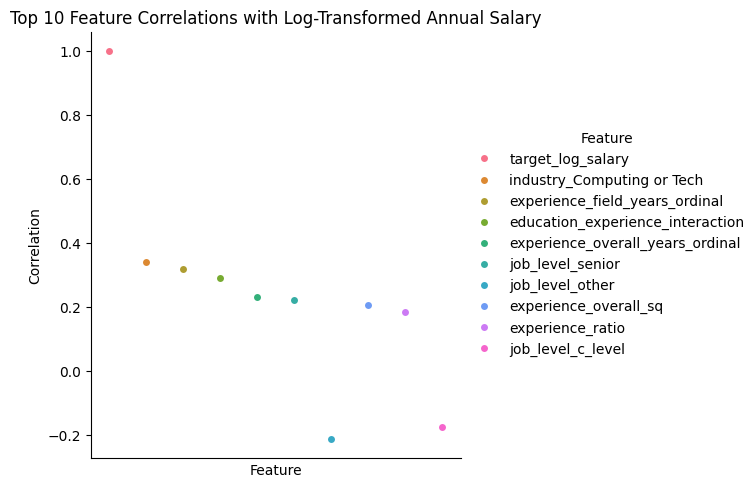

In [141]:
df_with_target = X_train_final.with_columns(
    y_train_log.rename({"annual_salary_log": "target_log_salary"})
)

numerical_cols = df_with_target.select(
    [
        pl.exclude(
            [
                col
                for col in df_with_target.columns
                if df_with_target[col].dtype == pl.UInt8 or col == "index"
            ]
        )
    ]
)

df = (
    pl.DataFrame(
        {
            "Feature": numerical_cols.columns,
            "Correlation": numerical_cols.corr().select(pl.col("target_log_salary"))
        }
    )
    .sort(pl.col("Correlation").abs(), descending=True)
    .head(10)
)

plt.figure(figsize=(24, 8))
sns.catplot(df, x="Feature", y ="Correlation", legend=True, hue="Feature", palette="husl", legend_out=True)

plt.title("Top 10 Feature Correlations with Log-Transformed Annual Salary")
plt.xticks([])
plt.savefig("../../figures/feature_correlation.png", dpi=300)